In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("example").getOrCreate()
file_path = 'time-series-19-covid-combined.csv'
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)
vietnam_data = spark_df.filter(col("Country/Region") == "Vietnam")
spark_df = vietnam_data.drop("Province/State")
spark_df.show()

23/12/21 03:41:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------+--------------+---------+---------+------+
|      Date|Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2020-01-22|       Vietnam|        0|        0|     0|
|2020-01-23|       Vietnam|        2|        0|     0|
|2020-01-24|       Vietnam|        2|        0|     0|
|2020-01-25|       Vietnam|        2|        0|     0|
|2020-01-26|       Vietnam|        2|        0|     0|
|2020-01-27|       Vietnam|        2|        0|     0|
|2020-01-28|       Vietnam|        2|        0|     0|
|2020-01-29|       Vietnam|        2|        0|     0|
|2020-01-30|       Vietnam|        2|        0|     0|
|2020-01-31|       Vietnam|        2|        0|     0|
|2020-02-01|       Vietnam|        6|        1|     0|
|2020-02-02|       Vietnam|        6|        1|     0|
|2020-02-03|       Vietnam|        8|        1|     0|
|2020-02-04|       Vietnam|        8|        1|     0|
|2020-02-05|       Vietnam|        8|        1|     0|
|2020-02-0

In [2]:
from pyspark.sql.functions import max, min
from pyspark.sql import functions

# DataFrame cần kiểm tra
df_to_check = spark_df

# List chứa tên các cột
columns = df_to_check.columns[2:]

# Tìm giá trị max và min cho từng cột
max_min_rows = []
for col in columns:
    max_value = df_to_check.select(max(col).alias("max_value")).collect()[0]["max_value"]
    min_value = df_to_check.select(min(col).alias("min_value")).collect()[0]["min_value"]

    max_row = df_to_check.filter(functions.col(col) == max_value).limit(1)
    min_row = df_to_check.filter(functions.col(col) == min_value).limit(1)

    max_min_rows.append((col, max_row, min_row))

# Hiển thị kết quả
for col, max_row, min_row in max_min_rows:
    print(f"Column: {col}")
    print("Max Value Row:")
    max_row.show(truncate=False)
    print("Min Value Row:")
    min_row.show(truncate=False)
    print("----------------------")

Column: Confirmed
Max Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2022-04-16|Vietnam       |10417887 |0        |42934 |
+----------+--------------+---------+---------+------+

Min Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2020-01-22|Vietnam       |0        |0        |0     |
+----------+--------------+---------+---------+------+

----------------------
Column: Recovered
Max Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2021-08-04|Vietnam       |181756   |54332    |2327  |
+----------+--------------+---------+---------+------+

Min Value Row:
+----------+--------------+---------+---------+------

In [3]:
from pyspark.sql.functions import mean, median

# Tính giá trị trung bình và trung vị cho từng cột
for col in columns:
    # Giá trị trung bình
    mean_value =df_to_check.select(mean(col)).collect()[0][0]

    # Giá trị trung vị
    median_value = df_to_check.select(median(col)).collect()[0][0]

    # In kết quả
    print(f"Column: {col}")
    print(f"Mean: {mean_value}")
    print(f"Median: {median_value}")
    print("----------------------")

Column: Confirmed
Mean: 788037.618872549
Median: 2491.0
----------------------
Column: Recovered
Mean: 1545.8921568627452
Median: 328.5
----------------------
Column: Deaths
Mean: 8709.484068627451
Median: 35.0
----------------------


In [4]:
from pyspark.sql.functions import col, count

# Tìm giá trị phổ biến và hiếm nhất cho từng cột
common_rare_values = []
for col_name in columns:
    # Tìm giá trị phổ biến (mode)
    most_common = df_to_check.groupBy(col_name).agg(count(col_name).alias("count")).orderBy(col("count").desc()).first()

    # Tìm giá trị hiếm nhất
    least_common = df_to_check.groupBy(col_name).agg(count(col_name).alias("count")).orderBy(col("count").asc()).first()

    common_rare_values.append((col_name, most_common[col_name], most_common["count"], least_common[col_name], least_common["count"]))

# Hiển thị kết quả
for col_name, common_value, common_count, rare_value, rare_count in common_rare_values:
    print(f"Column: {col_name}")
    print(f"Most Common Value: {common_value}, Count: {common_count}")
    print(f"Least Common Value: {rare_value}, Count: {rare_count}")
    print("----------------------")

Column: Confirmed
Most Common Value: 16, Count: 23
Least Common Value: 2142, Count: 1
----------------------
Column: Recovered
Most Common Value: 0, Count: 265
Least Common Value: 392, Count: 1
----------------------
Column: Deaths
Most Common Value: 35, Count: 254
Least Common Value: 22412, Count: 1
----------------------


In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình RandomForest sử dụng PySpark DataFrame
class RandomForest:
    def __init__(self, num_trees=10, max_depth=5, subsample_size=0.8):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.subsample_size = subsample_size
        self.trees = []

    def fit(self, data):
        for _ in range(self.num_trees):
            # Lấy mẫu dữ liệu con từ tập huấn luyện
            sampled_data = data.sample(withReplacement=True, fraction=self.subsample_size, seed=np.random.randint(1, 1000))

            # Tạo DataFrame chứa cột 'tree_prediction' cho cây quyết định
            tree_predictions = sampled_data.withColumn("tree_prediction", F.rand())

            # Thêm DataFrame vào danh sách cây
            self.trees.append(tree_predictions)

    def predict(self, data):
        # Tạo DataFrame chứa cột 'tree_prediction' cho mỗi cây
        predictions = data.withColumn("tree_prediction", F.lit(0.0))

        # Cập nhật dự đoán bằng cách kết hợp dự đoán từ tất cả các cây
        for i, tree in enumerate(self.trees):
            # Đổi tên cột 'tree_prediction' thành 'prediction_i' để tránh xung đột
            tree = tree.withColumnRenamed("tree_prediction", f"prediction_{i}")
            predictions = predictions.join(tree.select("features", f"prediction_{i}"), on="features", how="left")

        # Tính tổng dự đoán từ tất cả các cây và chia tổng cho số cây để có dự đoán trung bình
        predictions = predictions.fillna(0.0)  # Điền giá trị null bằng 0
        sum_cols = sum([F.col(f"prediction_{i}") for i in range(len(self.trees))])
        predictions = predictions.withColumn("prediction", sum_cols / len(self.trees)).drop(*[f"prediction_{i}" for i in range(len(self.trees))])

        return predictions

# Tạo mô hình
random_forest_model = RandomForest(num_trees=10, max_depth=5, subsample_size=0.8)

# Huấn luyện mô hình
random_forest_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = random_forest_model.predict(test_data)

# Hiển thị kết quả
predictions.show()



23/12/21 03:42:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------+---------+---------------+------------------+
|features|Confirmed|tree_prediction|        prediction|
+--------+---------+---------------+------------------+
|   [2.0]|        2|            0.0|0.7023019859908602|
|   [2.0]|        2|            0.0|0.6791654425727245|
|   [2.0]|        2|            0.0|0.6948307542845459|
|   [2.0]|        2|            0.0|0.6504257847785835|
|   [2.0]|        2|            0.0|0.7037811143941399|
|   [2.0]|        2|            0.0|0.6806445709760041|
|   [2.0]|        2|            0.0|0.6963098826878256|
|   [2.0]|        2|            0.0|0.6519049131818632|
|   [2.0]|        2|            0.0|0.6224008323741371|
|   [2.0]|        2|            0.0|0.5992642889560014|
|   [2.0]|        2|            0.0|0.6149296006678228|
|   [2.0]|        2|            0.0|0.5705246311618604|
|   [2.0]|        2|            0.0| 0.703901670059883|
|   [2.0]|        2|            0.0|0.6807651266417472|
|   [2.0]|        2|            0.0|0.6964304383

+--------+---------+----------+
|features|Confirmed|prediction|
+--------+---------+----------+
|   [2.0]|        2| 1.7718226|
|   [2.0]|        2| 1.7718226|
|   [8.0]|        8| 7.0872903|
|   [8.0]|        8| 7.0872903|
|  [15.0]|       15|  13.28867|
|  [16.0]|       16| 14.174581|
|  [16.0]|       16| 14.174581|
|  [16.0]|       16| 14.174581|
|  [16.0]|       16| 14.174581|
|  [16.0]|       16| 14.174581|
|  [16.0]|       16| 14.174581|
| [218.0]|      218| 193.12866|
| [251.0]|      251| 222.36374|
| [266.0]|      266|  235.6524|
| [268.0]|      268| 237.42422|
| [268.0]|      268| 237.42422|
| [270.0]|      270| 239.19604|
| [271.0]|      271| 240.08197|
| [288.0]|      288| 255.14246|
| [288.0]|      288| 255.14246|
+--------+---------+----------+
only showing top 20 rows



Mean Squared Error (MSE): 110392059143.62549


R-squared: 0.9840409541554596
+-------------+----------+
|     features|prediction|
+-------------+----------+
|[1.0417887E7]| 9229324.0|
|[1.0394533E7]| 9208634.0|
|[1.0320599E7]| 9143135.0|
|[1.0297587E7]| 9122749.0|
|[1.0272964E7]| 9100935.0|
| [1.025016E7]| 9080733.0|
|[1.0198236E7]| 9034733.0|
|[1.0169929E7]| 9009655.0|
|[1.0135789E7]| 8979410.0|
|[1.0070692E7]| 8921740.0|
|  [9980464.0]| 8841806.0|
|  [9922040.0]| 8790047.0|
|  [9867045.0]| 8741327.0|
|  [9818328.0]| 8698168.0|
|  [9716282.0]| 8607764.0|
|  [9650663.0]| 8549631.0|
|  [9564609.0]| 8473395.0|
|  [9472254.0]| 8391577.0|
|  [9386489.0]| 8315596.5|
|  [9274849.0]| 8216693.5|
+-------------+----------+
only showing top 20 rows



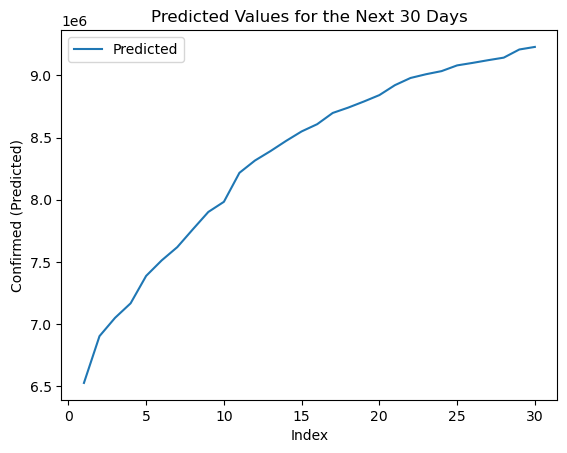

In [23]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình hồi quy tuyến tính sử dụng Gradient Descent
class LinearRegressionGD:
    def __init__(self, lr=0.01, num_iters=100):
        self.lr = lr
        self.num_iters = num_iters
        self.weights = None

    def fit(self, data):
        # Chuyển đổi DataFrame thành RDD để sử dụng trong quá trình tính toán
        rdd_data = data.rdd.map(lambda x: (DenseVector(x[0]), x[1]))

        # Khởi tạo trọng số ngẫu nhiên
        self.weights = DenseVector([0.0] * len(rdd_data.first()[0]))

        # Gradient Descent
        for _ in range(self.num_iters):
            gradient = rdd_data.map(lambda x: ((x[0].dot(self.weights) - x[1]) * x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            gradient = gradient[0] / gradient[1]
            self.weights -= self.lr * gradient
            

    def predict(self, data):
        predict_udf = F.udf(lambda x: float(x.dot(self.weights)), returnType=FloatType())
        return data.withColumn("prediction", predict_udf(data["features"]))
    

# Tạo mô hình
linear_regression_model = LinearRegressionGD(lr=0.0000000000001, num_iters=5)

# Huấn luyện mô hình
linear_regression_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = linear_regression_model.predict(test_data)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator

# Cast the prediction column to DoubleType
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")


# 
new_feature_column = "features"
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol=new_feature_column)
recent_data = spark_df.select("Confirmed").orderBy("Date", ascending=False).limit(30)
recent_data = vec_assembler.transform(recent_data).select(new_feature_column)

# Dự đoán 30 ngày tiếp theo
predictions_30_days = linear_regression_model.predict(recent_data)

# Hiển thị kết quả
predictions_30_days.show()

import matplotlib.pyplot as plt
import numpy as np

# 
prediction_values = predictions_30_days.select("prediction").rdd.flatMap(lambda x: x).collect()

# 
index_values = np.arange(1, 31)

# 
prediction_values = prediction_values[::-1]

# 
plt.plot(index_values, prediction_values, label='Predicted')
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Index')
plt.ylabel('Confirmed (Predicted)')
plt.legend()
plt.show()




In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("SVMExample").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình SVM sử dụng PySpark DataFrame
class SVM:
    def __init__(self, lr=0.01, num_iters=100):
        self.lr = lr
        self.num_iters = num_iters
        self.weights = None

    def fit(self, data):
        # Chuyển đổi DataFrame thành RDD để sử dụng trong quá trình tính toán
        rdd_data = data.rdd.map(lambda x: (DenseVector(x[0]), x[1]))

        # Khởi tạo trọng số ngẫu nhiên
        self.weights = DenseVector([0.0] * len(rdd_data.first()[0]))
        # Gradient Descent
        for _ in range(self.num_iters):
            gradient = rdd_data.map(lambda x: ((x[0].dot(self.weights) - x[1]) * x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            gradient = gradient[0] / gradient[1]
            self.weights -= self.lr * gradient

    def predict(self, data):
        predict_udf = F.udf(lambda x: float(x.dot(self.weights)), returnType=FloatType())
        return data.withColumn("prediction", F.when(predict_udf(data["features"]) >= 0.5, 1.0).otherwise(0.0))

# Tạo mô hình
svm_model = SVM(lr=0.01, num_iters=100)

# Huấn luyện mô hình
svm_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = svm_model.predict(test_data)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator

# Cast the prediction column to DoubleType
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")


23/12/21 03:43:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
/home/trung/spark-3.5.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py:516: RuntimeWarning: overflow encountered in add
/home/trung/spark-3.5.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py:516: RuntimeWarning: overflow encountered in multiply


+--------+---------+----------+
|features|Confirmed|prediction|
+--------+---------+----------+
|   [2.0]|        2|       1.0|
|   [2.0]|        2|       1.0|
|   [8.0]|        8|       1.0|
|   [8.0]|        8|       1.0|
|  [15.0]|       15|       1.0|
|  [16.0]|       16|       1.0|
|  [16.0]|       16|       1.0|
|  [16.0]|       16|       1.0|
|  [16.0]|       16|       1.0|
|  [16.0]|       16|       1.0|
|  [16.0]|       16|       1.0|
| [218.0]|      218|       1.0|
| [251.0]|      251|       1.0|
| [266.0]|      266|       1.0|
| [268.0]|      268|       1.0|
| [268.0]|      268|       1.0|
| [270.0]|      270|       1.0|
| [271.0]|      271|       1.0|
| [288.0]|      288|       1.0|
| [288.0]|      288|       1.0|
+--------+---------+----------+
only showing top 20 rows



Mean Squared Error (MSE): 8481105655633.697
R-squared: -0.22608777316629003


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Khởi tạo phiên Spark
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

# Chọn các cột quan trọng (Date và Confirmed)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", df["Date"].cast("timestamp"))

# Tạo VectorAssembler để kết hợp các đặc trưng vào một cột vector
vector_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vector_assembler.transform(df)

# Chọn số cụm bạn muốn phân loại
k = 3  # Số cụm (clusters) bạn muốn tạo

# Tạo mô hình KMeans
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(df)

# Dự đoán cụm cho mỗi quốc gia hoặc tỉnh thành
predictions = model.transform(df)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator
# Cast the prediction column to DoubleType
predictions = predictions.withColumn("cluster", col("cluster").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="cluster", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="cluster", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")
